# Deep Learning
## Summative assessment
### Coursework 3

In [105]:
import os
os.getcwd()

'/tf'

#### Instructions

This coursework is released on **Wednesday 20th March 9.00** and is due by **Wednesday 24th April 23.59**. It is worth **50%** of your overall mark. There are 4 questions in this assessment, and a total of 100 marks are available. **You should attempt to answer all questions.** In addition to the total number of marks per question below, an additional 5 marks is available for presentation and clarity/quality of code.

This assessment assesses your ability to design, implement, train and evaluate a generative deep learning model for a spoken audio dataset.

You can make imports as and when you need them throughout the notebook, and add code cells where necessary. Make sure your notebook executes correctly in sequence before submitting.

#### Submission instructions

The submission for this assessment will consist of a notebook (.ipynb file), PDF report and model submission.

Ensure your notebook executes correctly in order. Save your notebook .ipynb file **after you have executed it** (so that outputs are all showing). It is recommended to also submit a PDF/HTML copy of your executed notebook, in case the .ipynb file is corrupted for some reason.

Upload a zip file containing your notebook, separate PDF/HTML file(s), model(s) and any other relevant files to Coursera by the deadline above.

This assignment must be attempted individually; your submission must be your own, unaided work. Candidates are prohibited from discussing assessed coursework, and must abide by [Imperial College’s rules](https://www.imperial.ac.uk/media/imperial-college/administration-and-support-services/registry/academic-governance/public/academic-policy/academic-integrity/Examination-and-assessments---academic-integrity.pdf) regarding academic integrity and plagiarism. Unless specifically authorised within the assignment instructions, the submission of output from [generative AI tools](https://www.imperial.ac.uk/about/leadership-and-strategy/provost/vice-provost-education/generative-ai-tools-guidance/) (e.g., ChatGPT) for assessed coursework is prohibited. Violations will be treated as an examination offence. Enabling other candidates to plagiarise your work constitutes an examination offence. To ensure quality assurance is maintained, departments may choose to invite a random selection of students to an ‘authenticity interview’ on their submitted assessments.

In [2]:
! pip install pydub==0.25.1 -q


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python -m pip install --upgrade pip


In [69]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import pandas as pd
import os
from IPython.display import Audio, display

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Layer, Conv2D, Conv2DTranspose
from tensorflow.keras import Model, Sequential, Input
from tensorflow.keras.metrics import Mean
from tensorflow.keras.datasets import mnist

#### The Free Spoken Digit Dataset (FSDD)

This assessment makes use of the [Free Spoken Digit Dataset](https://github.com/Jakobovski/free-spoken-digit-dataset). This dataset consists of recordings of spoken digits by a number of different speakers, all recorded at a sample rate of 8kHz. The recordings are trimmed so that they have near minimal silence at the beginnings and ends.

For this assessment, we will use the version of the dataset made available through TensorFlow Datasets ([https://www.tensorflow.org/datasets/catalog/spoken_digit](https://www.tensorflow.org/datasets/catalog/spoken_digit)).

The dataset consists 2,500 recordings from 5 different speakers. Using the TensorFlow Datasets API, this dataset can be downloaded and stored directly in a Dataset object using the code below.

In [4]:
ds = tfds.load(
    'spoken_digit',
    split='train',
    data_dir=os.path.join("data", "spoken_digit"),
    shuffle_files=False
)

2024-04-21 15:00:57.082270: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-21 15:00:57.197211: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-21 15:00:57.198095: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [5]:
ds.element_spec

{'audio': TensorSpec(shape=(None,), dtype=tf.int64, name=None),
 'audio/filename': TensorSpec(shape=(), dtype=tf.string, name=None),
 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}

#### VQ-VAE

The VQ-VAE was first developed in the following paper:

* van den Oord, A., Vinyals, O. & Kavukcuoglu, K. (2017), "Neural discrete representation learning", _Proceedings of the 31st International Conference on Neural Information Processing Systems_, 6309-6318.

In this assessment you will develop and train a vector-quantised variational autoencoder (VQ-VAE) model. This is a variant of the VAE algorithm that makes use of a discrete latent space. In particular, the VQ-VAE defines a _codebook_ $\mathbf{e} \in \mathbb{R}^{K \times D}$ for the latent embedding space, consisting of $K$ latent embedding vectors $e_i$ ($i=1,\ldots,K$), each of dimension $D$. The algorithm involves training encoder and decoder networks as usual. However, for a given input $x$, the encoder output $E(x) \in \mathbb{R}^D$ is quantised to the nearest latent embedding vector:

$$VQ(E(x)) = e_k,\quad\textrm{where }k = \underset{j}{\arg\min}||E(x) - e_j||_2,$$

where the $||\cdot||_2$ norm above is the Euclidean norm in $\mathbb{R}^D$. This quantized latent vector is then passed through the decoder to output the likelihood $p_\theta(x \mid z)$ as usual.

The quantisation stage of the VQ-VAE means that it is not possible to compute gradients with respect to the encoder variables. The solution to this problem in the VQ-VAE is to use the _straight through estimator_, in which the gradients computed with respect to the quantised embeddings are simply passed unaltered to the encoder. This process means that the codebook embeddings $e_i$ do not receive any gradient updates (for details, refer to the implementation referenced in question 3, which makes this process explicit). The VQ-VAE objective therefore adds two additional terms to learn the codebook embeddings:

$$
L = \mathbb{E}_{q_\phi(z \mid x)}[\log p_\theta(x \mid z) ] + ||\textrm{sg}[E(x)] - VQ(E(x))||^2_2 + \beta || E(x) - \textrm{sg}[VQ(E(x))]||_2^2
$$

In the above, $\textrm{sg}$ is the _stop gradient_ operator that is defined as identity in the forward pass but has zero partial derivates (see [`tf.stop_gradient`](https://www.tensorflow.org/api_docs/python/tf/stop_gradient)). This means that when evaluating the loss function above, the stop gradient operator can be ignored, but when computing derivatives of the loss with respect to the model parameters, the partial derivatives of $\textrm{sg}[E(x)]$ and $\textrm{sg}[VQ(E(x))]$ with respect to the model parameters will be zero. The constant $\beta$ is usually taken set to $\beta=0.25$ by default, as in the original paper.

The first term in the objective $L$ above is the reconstruction loss, the second term is the _codebook loss_, and the third term is the _commitment loss_. The Kullback-Leibler divergence term in the ELBO is constant and so is ignored for training.

In this assessment, you will design, implement, train and evaluate a VQ-VAE for the spoken digit dataset, and use it to learn a generative model of the spoken audio.

### Question 1 (Total 15 marks)

The loaded Dataset returns a dictionary with keys `"audio"`, `"audio/filename"` and `"label"`. For this assessment you will only need the `"audio"` entry, and the other entries can be discarded.

In this question, you should carry out a basic exploration and analysis of the dataset; computing, displaying and visualising any properties you deem to be relevant. You can also use comments and/or markdown as appropriate.

All of the Dataset preparation/preprocessing for question 2a) should be done in this question, so that it is ready for training the VQ-VAE.

_Hint: an audio file can be played within a jupyter notebook using the `Audio` class from the `IPython.display` module (imported above). See [here](https://ipython.org/ipython-doc/3/api/generated/IPython.display.html) for usage._

**(15 marks)**

#### Exploratory Data Analysis

In [6]:
# Check cardinality of the dataset
print(tf.data.experimental.cardinality(ds).numpy())

2500


In [7]:
# Get the maximum length of the audio data
max_len = 0
for elem in ds.as_numpy_iterator():
    max_len = max(elem['audio'].shape[0],max_len)

print(max_len)

18262


In [8]:
# Load the first 6 elements into a list and print the shapes of the audio data
sample_list =[]
for element in ds.take(6):
    print(element['audio'])
    sample_list.append(element)

tf.Tensor([   0    0 -256 ... -512 -256 -512], shape=(1525,), dtype=int64)
tf.Tensor([   0    0    0 ... -256    0    0], shape=(2929,), dtype=int64)
tf.Tensor([-10  -6 -25 ... -26  -8 -14], shape=(6457,), dtype=int64)
tf.Tensor([ 0  2 -3 ... -3  0  2], shape=(3360,), dtype=int64)
tf.Tensor([-256    0 -256 ... -512    0    0], shape=(2746,), dtype=int64)
tf.Tensor([-6 20  7 ...  5 21 43], shape=(3306,), dtype=int64)


The above shows that the dimension of the data varies from input to input. This is a bit of an issue, as in tensorflow dimensions must be fixed at least throughout a batch (see [here](https://stackoverflow.com/questions/47479587/how-to-feed-input-with-changing-size-in-tensorflow)). The solution would be to fix the length of the input by finding the maximum length and using `np.pad`.

Another issue is the fact that the data is currently integers. For our purposes, we will need to convert this to floats. [SOURCE]

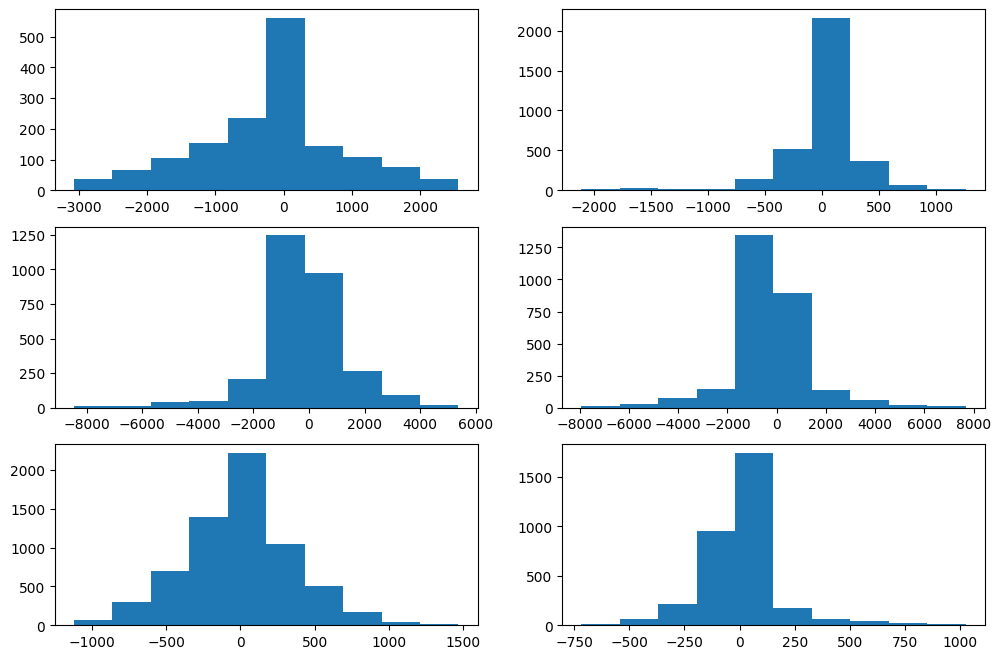

In [9]:
# Visualise the distribution of values using histograms
fig, ax = plt.subplots(nrows=3,ncols=2,figsize=(12,8))
for i in range(3):
    ax[i,0].hist(sample_list[i]['audio'].numpy())
    ax[i,1].hist(sample_list[i+3]['audio'].numpy())

As expected, the soundwave data is has a relatively symmetrical distribution, and is centered upon zero. My assumption is that padding the audio data with zeros to solve for the issue mention above will essentially be equivalent to adding silence to the audio clips.

In this next section if the EDA, I will explore compare the time and spectral representations of the audio clips to see whether there are any similarities withing the digit groups

In [10]:
# Create a nested list of 5 audio samples per digit
samples = []
for i in range(10):
    digit_sample = list(ds.filter(lambda x: x['label']==i).take(4))
    samples.append(digit_sample)

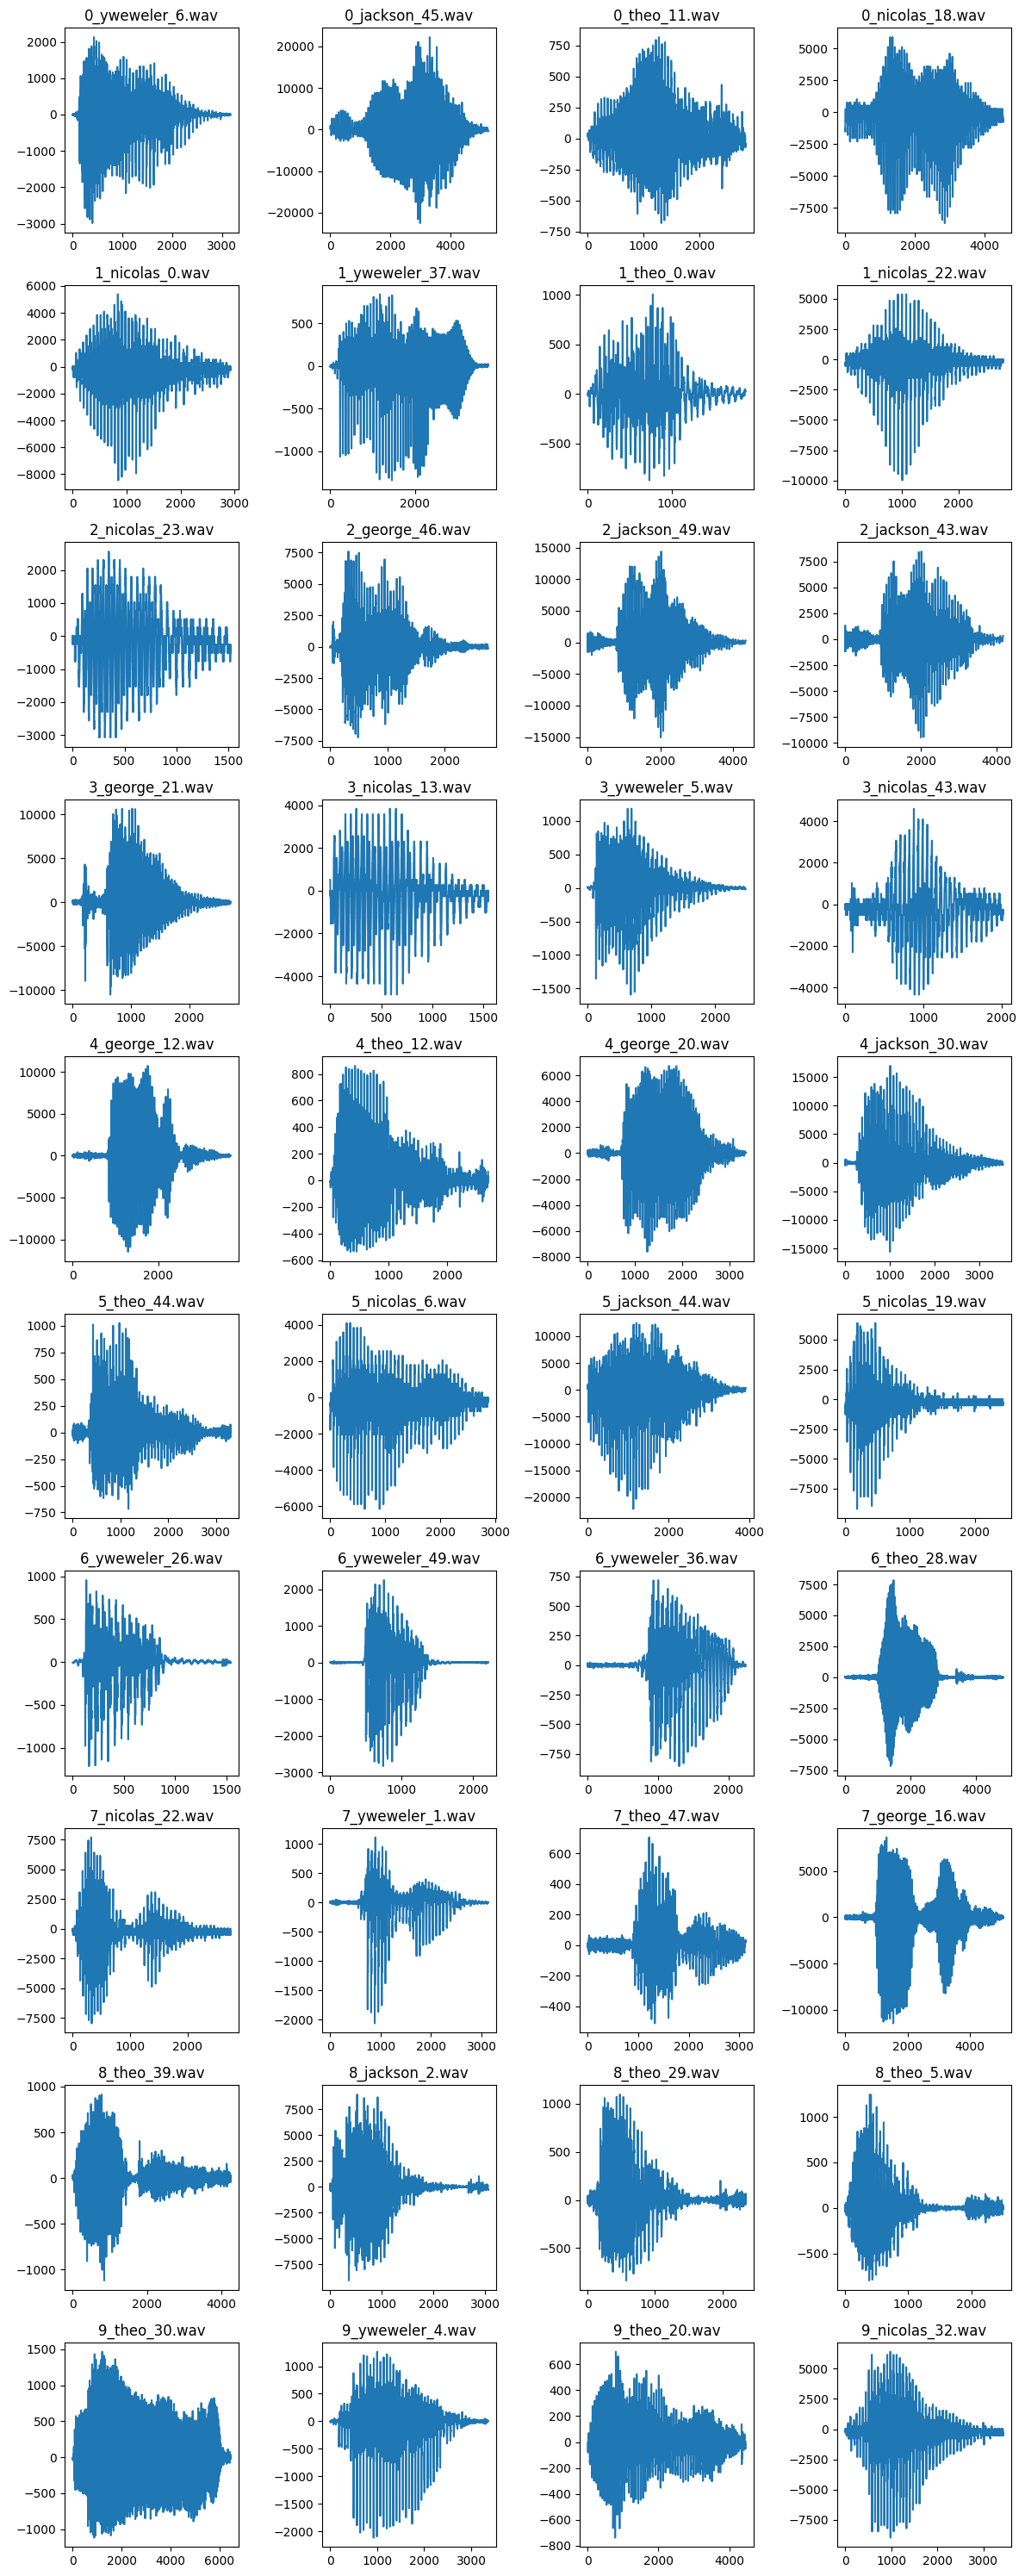

In [11]:
# Plot the amplitudes for each digit
fig, ax = plt.subplots(nrows=10,ncols=4,figsize=(12,30))

for digit in range(10):
    for col in range(4):
        title = samples[digit][col]['audio/filename'].numpy().decode('utf-8')
        data = samples[digit][col]['audio'].numpy()
        ax[digit][col].plot(data)
        ax[digit][col].set_title(title)
plt.tight_layout()
plt.show()

Distinctions across digits is more obvious for some digits than others. "seven" particularly seems to follow the same pattern. Next, I check the spectrogram

In [12]:
# Pad audio data
pad_len = 18300

for digit in range(10):
    for sample in range(4):
        samples[digit][sample]['audio'] = tf.concat([samples[digit][sample]['audio'],tf.zeros(pad_len-samples[digit][sample]['audio'].shape[0],tf.int64)],0)

(128, 129)


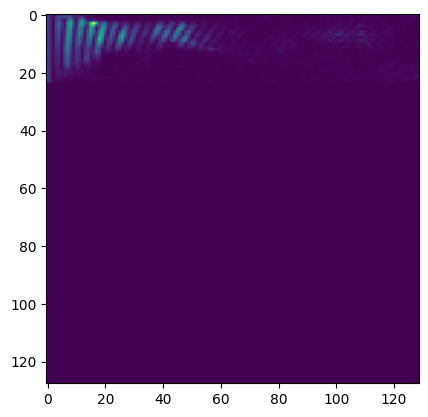

In [13]:
# Take one audio waveform and experiment to find the best frame length and step
frame_length = 255
frame_step =141

waveform = tf.cast(samples[9][3]['audio'],tf.float64)
stft = tf.signal.stft(waveform,frame_length,frame_step)
spectrogram = tf.abs(stft)
print(spectrogram.numpy().shape)
plt.imshow(spectrogram.numpy())
plt.show()

(127, 129)


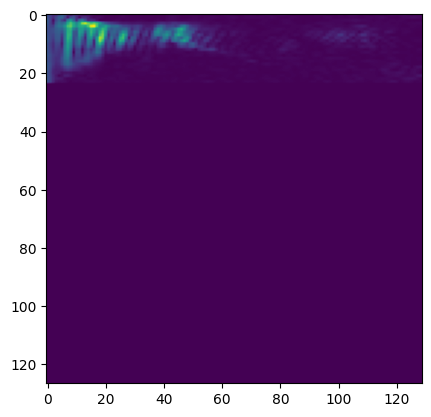

In [14]:
# Take one audio waveform and experiment to find the best frame length and step
frame_length = 155
frame_step = 143

waveform = tf.cast(samples[9][3]['audio'],tf.float64)
stft = tf.signal.stft(waveform,frame_length,frame_step)
spectrogram = tf.abs(stft)
print(spectrogram.numpy().shape)
plt.imshow(spectrogram.numpy())
plt.show()

(127, 129)


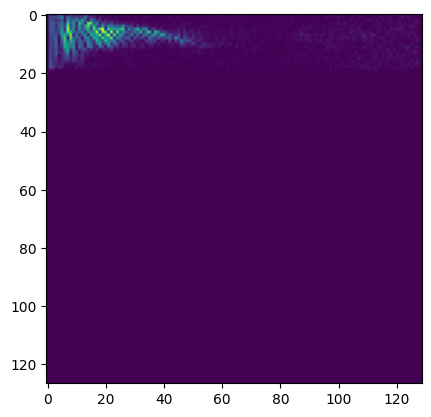

In [15]:
# Take one audio waveform and experiment to find the best frame length and step
frame_length = 155
frame_step = 143

waveform = tf.cast(samples[1][3]['audio'],tf.float64)
stft = tf.signal.stft(waveform,frame_length,frame_step)
spectrogram = tf.abs(tf.math.imag(stft))
print(spectrogram.numpy().shape)
plt.imshow(spectrogram.numpy())
plt.show()

(33, 33)


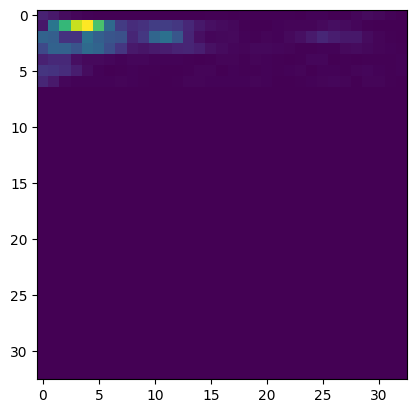

In [16]:
# Take one audio waveform and experiment to find the best frame length and step
frame_length = 55
frame_step = 555

waveform = tf.cast(samples[9][3]['audio'],tf.float64)
stft = tf.signal.stft(waveform,frame_length,frame_step)
spectrogram = tf.abs(stft)
print(spectrogram.numpy().shape)
plt.imshow(spectrogram.numpy())
plt.show()

Based on the above, setting `frame_length`=155 and `frame_step`=143. Below I plot the magnitude and the phase for one of each digit

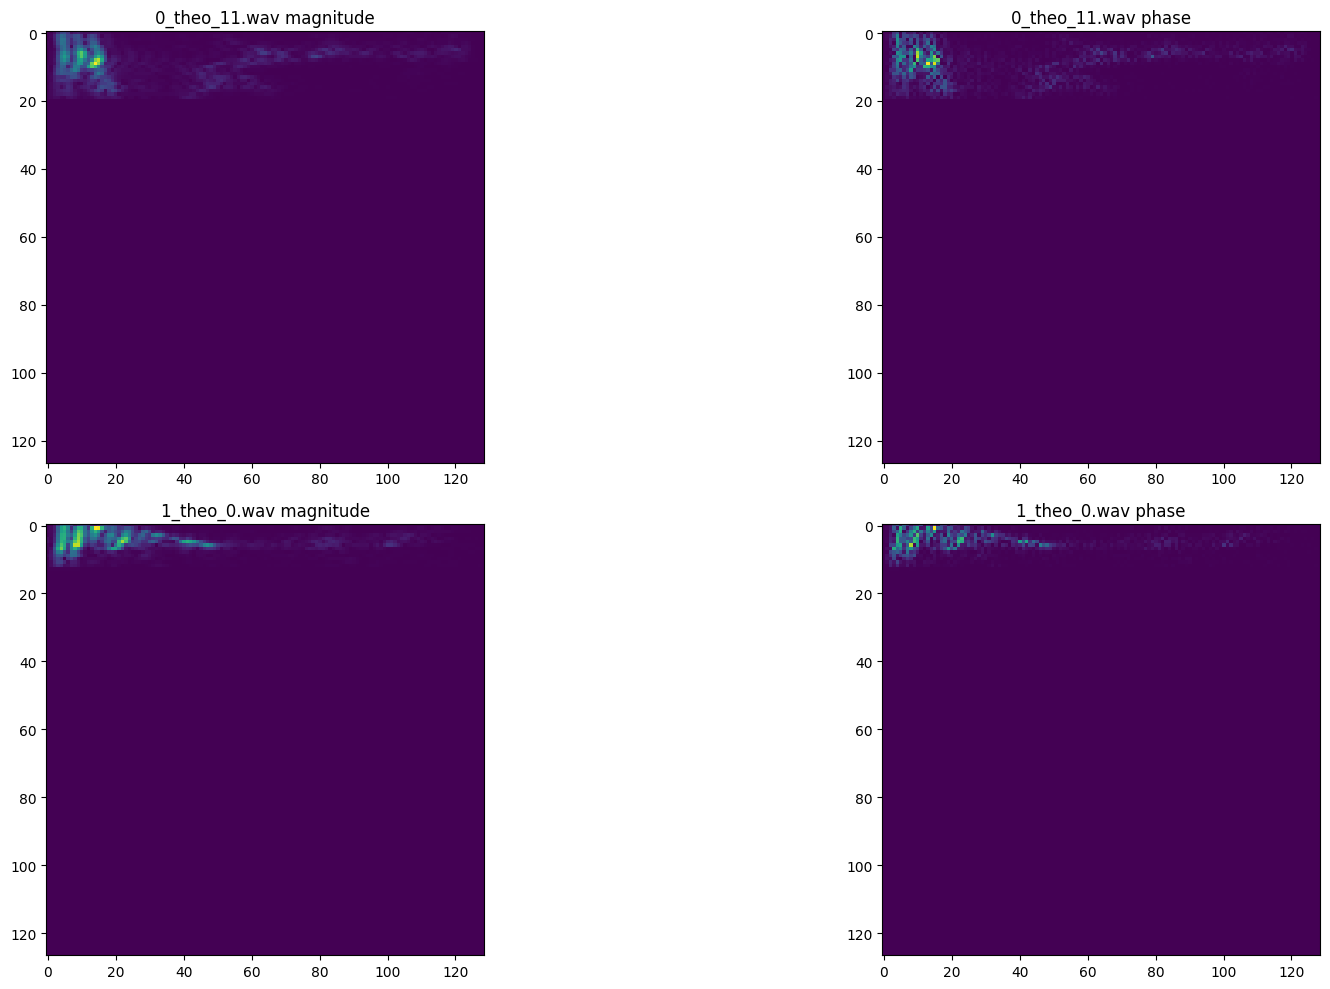

In [17]:
# Display all spectograms
frame_length=155
frame_step=143
fig, ax = plt.subplots(ncols=2,nrows=2,figsize=(20,10))
for digit in range(2):
    data = tf.cast(samples[digit][2]['audio'],tf.float64)
    name = samples[digit][2]['audio/filename'].numpy().decode('utf-8')
    stft = tf.signal.stft(data,frame_length,frame_step)
    magnitude = tf.abs(stft)
    phase = tf.abs(tf.math.imag(stft))
    ax[digit,0].imshow(magnitude.numpy())
    ax[digit,0].set_title(name+' magnitude')
    ax[digit,1].imshow(phase.numpy())
    ax[digit,1].set_title(name+' phase')
fig.tight_layout()
fig.show()
    

In [18]:
# Retrieve audio data and play it
sample_waveform = samples[7][2]['audio']
Audio(sample_waveform,rate=8000)

In [19]:
# Now transform it into a spectogram
stft = tf.signal.stft(tf.cast(sample_waveform,tf.float64),frame_length,frame_step)

# Separate magnitude and phase into different channels
spectrogram_data = tf.stack([tf.math.real(stft),tf.math.imag(stft)],axis=2)
spectrogram_data.shape

TensorShape([127, 129, 2])

In [20]:
# Now recombine back into single spectrogram and transform back into audio
stft_reconstructed = tf.dtypes.complex(spectrogram_data[:,:,0],spectrogram_data[:,:,1])

inverse_stft = tf.signal.inverse_stft(
    stft_reconstructed,
    frame_length,
    frame_step,
    window_fn=tf.signal.inverse_stft_window_fn(frame_step))

Audio(inverse_stft,rate=8000)

The above demsonstrates the the Short Time Fourier Transformation is revetable, and therefore enables us to reconstruct the audio from the spectrograms.

#### Data Pre-processing

Based on the findings above, I have constructed the pre-processing steps below. First, I split the dataset into training and validation sets, per the guidence given [here](https://github.com/Jakobovski/free-spoken-digit-dataset); "Recordings numbered `0-4` (Recordings numbered `0-4` (inclusive) are in the test and `5-49` are in the training set."

In [21]:
# Split the datasets into train and test based on the file name
train_ds = ds.filter(lambda x: tf.strings.to_number(tf.strings.split(tf.strings.split(x['audio/filename'],sep='_')[2],sep='.')[0])>4)
val_ds = ds.filter(lambda x: tf.strings.to_number(tf.strings.split(tf.strings.split(x['audio/filename'],sep='_')[2],sep='.')[0])<=4)

In [22]:
# Select the audio data only, convert to float64, and rpad it to the length of 18300 from the data exploration stage
def extract_audio(elem):
    out = tf.cast(elem['audio'],tf.float64)
    out = tf.concat([out,tf.zeros(18300 - tf.shape(out)[0],tf.float64)],0)
    return out

train_ds = train_ds.map(extract_audio)
val_ds = val_ds.map(extract_audio)

In [23]:
# Convert the data into spectrograms with the above frame length and frame step
frame_length = 155
frame_step = 143

def get_spectrograms(elem):
    stft = tf.signal.stft(elem,frame_length,frame_step)
    out = tf.stack([tf.math.real(stft),tf.math.imag(stft)],axis=2)
    return out

train_ds = train_ds.map(get_spectrograms)
val_ds = val_ds.map(get_spectrograms)

In [24]:
# Make sure we got the right shape
for elem in train_ds.take(1):
    print(elem.shape)

(127, 129, 2)


In [25]:
# Shuffle the training set
train_ds = train_ds.shuffle(30)

# Batch training and validation set
train_ds = train_ds.batch(50)
val_ds = val_ds.batch(50)

In [26]:
# Check shape
for batch in train_ds.take(1):
    print(batch.shape)

(50, 127, 129, 2)


In [27]:
# Prefetch training set
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

### Question 2 (Total 25 marks)

a) In the VQ-VAE, the variational posterior output by the encoder is deterministic:

$$q_\phi(z = e_k \mid x) = \left\{
\begin{array}{l}
~1 \quad\textrm{for}\quad k=\underset{j}{\arg\min} ||E(x) - e_j||\\
~0 \quad\textrm{otherwise}
\end{array}
\right.
$$

where in the above, $\phi$ represents the parameters of the encoder. Show that by choosing a simple uniform distribution over the codebook vectors $e_i$ as the prior distribution $p(z)$, the KL-divergence term of the ELBO objective is equal to a constant.

**(5 marks)**

Since we are choosing a simple uniform distribution over the codebook vectors $e_i$, this entails:
$$
\forall k, p(z=e_k) = \frac{1}{K}
$$

Solving for the KL divergence term in the ELBO loss, we have:

$$
D_{KL}(q_{\phi}(z|x)||p(z)) = \mathbb{E}_{q_\phi}\left[\log \frac{q_{\phi}(z|x)}{p(z)}\right] 
= \sum_{k=1}^{K}\log \frac{q_{\phi}(z=e_k|x)}{p(z=e_k)}q_{\phi}(z=e_k|x)
= \log (\frac{1}{1/K} \cdot 1)
=\log (K)
$$

b) The VQ-VAE as described above has an implementation that is available on the Keras website [here](https://keras.io/examples/generative/vq_vae/). In particular, the implementation of the vector quantisation and addition of the codebook and commitment loss is done with the `VectorQuantizer` layer.

You should write your own custom Layer class that is based on the `VectorQuantizer` layer, but with the following amendments:

1) The codebook loss should be removed, and instead the layer should use exponential moving average updates for the codebook during training, as follows:
$$
N_i^{(t)} := N_i^{(t-1)} * \gamma + n_i^{(t)}(1 - \gamma),\quad m_i^{(t)} := m_i^{(t-1)} * \gamma + \sum_j^{n_i^{(t)}} E(x)_{i,j}^{(t)}(1-\gamma),\quad e_i^{(t)} :=\frac{m_i^{(t)}}{N_i^{(t)}},\qquad i=1,\ldots,K
$$
where $n_i^{(t)}$ is the number of vectors in $E(x)$ in the minibatch that are quantized to codebook vector $e_i$ (cluster size), and $0 < \gamma < 1$ is a decay parameter, normally set to $\gamma=0.99$ as default. The moving averages are typically initialised as $m_i^{(0)} = e_i^{(0)}$ and $N_i^{(0)} = 0$. Note that the above update is independent of the gradient-based optimizer used to update the parameters of the encoder and decoder networks.

2) In place of the (single) codebook vector quantisation, your custom Layer class should use _residual vector quantisation_ (RVQ). This is a multi-stage vector quantiser, which involves $N_q$ layers of vector quantisation as follows. Define a sequence of codebooks $\mathbf{e}^{(j)}\in\mathbb{R}^{K\times D}$, $j=1,\ldots,N_q$. Codebook $\mathbf{e}^{(j)}$ consists of $K$ latent embedding vectors $e_i^{(j)}$, each of dimension $D$ as before.

The encoder output $E(x)$ is first quantised using the first codebook:

$$VQ^{(1)}(E(x)) = e_k^{(1)},\quad\textrm{where }k = \underset{j}{\arg\min}||E(x) - e_j^{(1)}||_2,$$
    
The residual $\hat{e}^{(1)} := E(x) - VQ^{(1)}(E(x))$ is then quantised using the second codebook to give $VQ^{(2)}(\hat{e}^{(1)})$, and so on. The RVQ layer then sends the sum of the quantised vectors on to the decoder. The algorithm is summarised in the following pseudocode.

<img src="figures/rvq_pseudocode.png" alt="RVQ pseudocode" style="width: 450px;"/>

**(15 marks)**

In [28]:
class VectorQuantizer(Layer):
    def __init__(self, num_embeddings, embedding_dim, beta=0.25, **kwargs):
        super().__init__(**kwargs)
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings

        # The `beta` parameter is best kept between [0.25, 2] as per the paper.
        self.beta = beta

        # Initialize the embeddings which we will quantize.
        w_init = tf.random_uniform_initializer()
        self.embeddings = tf.Variable(
            initial_value=w_init(
                shape=(self.embedding_dim, self.num_embeddings), dtype="float32"
            ),
            trainable=True,
            name="embeddings_vqvae",
        )

    def call(self, x):
        # Calculate the input shape of the inputs and
        # then flatten the inputs keeping `embedding_dim` intact.
        input_shape = tf.shape(x)
        flattened = tf.reshape(x, [-1, self.embedding_dim])

        # Quantization.
        encoding_indices = self.get_code_indices(flattened)
        encodings = tf.one_hot(encoding_indices, self.num_embeddings)
        quantized = tf.matmul(encodings, self.embeddings, transpose_b=True)

        # Reshape the quantized values back to the original input shape
        quantized = tf.reshape(quantized, input_shape)

        # Calculate vector quantization loss and add that to the layer. You can learn more
        # about adding losses to different layers here:
        # https://keras.io/guides/making_new_layers_and_models_via_subclassing/. Check
        # the original paper to get a handle on the formulation of the loss function.
        commitment_loss = tf.reduce_mean((tf.stop_gradient(quantized) - x) ** 2)
        codebook_loss = tf.reduce_mean((quantized - tf.stop_gradient(x)) ** 2)
        self.add_loss(self.beta * commitment_loss + codebook_loss)

        # Straight-through estimator.
        quantized = x + tf.stop_gradient(quantized - x)
        return quantized,encoding_indices,encodings,input_shape

    def get_code_indices(self, flattened_inputs):
        # Calculate L2-normalized distance between the inputs and the codes.
        similarity = tf.matmul(flattened_inputs, self.embeddings)
        distances = (
            tf.reduce_sum(flattened_inputs ** 2, axis=1, keepdims=True)
            + tf.reduce_sum(self.embeddings ** 2, axis=0)
            - 2 * similarity
        )

        # Derive the indices for minimum distances.
        encoding_indices = tf.argmin(distances, axis=1)
        return encoding_indices

In [29]:
# generate test batch
test_batch = tf.random.normal((50,20))

In [30]:
vq_layer = VectorQuantizer(10,20)

In [31]:
print([x.name for x in vq_layer.trainable_weights])

['embeddings_vqvae:0']


In [32]:
out,indices,encodings,input_shape = vq_layer(test_batch)
print(out)

tf.Tensor(
[[-0.02056903  0.00382566 -0.01991951  0.00722751 -0.03344754 -0.03955913
   0.04386029 -0.02221739  0.00016159  0.03348625  0.01877522 -0.04545885
  -0.03528672  0.03919351  0.02393731  0.03525019  0.00908363  0.04120597
   0.01127946  0.03198981]
 [-0.04379112  0.04227901  0.03270608 -0.02735032 -0.00178427  0.03797621
   0.0424394  -0.01303488  0.02862424 -0.01466334 -0.03688383 -0.04903087
  -0.02341616  0.04167295 -0.00806129  0.02523524  0.03825742 -0.02156925
   0.03845757  0.00904429]
 [ 0.00721583 -0.02812624 -0.004472    0.03693599 -0.00658596 -0.02481721
  -0.01048374 -0.02791132  0.01843047  0.0104306  -0.01906741  0.00355387
   0.02624536  0.02147377  0.01318766 -0.04995835  0.00710468  0.02827621
   0.01835519  0.02527878]
 [-0.03772664 -0.00859427  0.01821858 -0.01676048 -0.01886046 -0.00424939
  -0.03561745 -0.04413128  0.03998721  0.02975309  0.01540506  0.02066652
   0.04577687  0.04026628 -0.03583229  0.02499938  0.03891456  0.00094688
  -0.03767753 -0.019

In [33]:
test_batch

<tf.Tensor: shape=(50, 20), dtype=float32, numpy=
array([[ 5.00694394e-01,  1.19237351e+00, -5.95029891e-01,
        -4.82522070e-01,  1.03557192e-01,  1.03808844e+00,
        -3.12044788e-02, -1.32686198e+00,  8.87136698e-01,
         4.91790384e-01,  1.58552444e+00, -8.75791311e-01,
        -2.87122697e-01,  1.04042590e+00, -1.44733846e-01,
         1.27823853e+00, -8.92453253e-01,  6.76151365e-02,
        -2.86783367e-01, -4.25984323e-01],
       [ 5.30734837e-01,  4.76201326e-01, -5.69338858e-01,
        -1.65881798e-01,  7.58547723e-01, -6.59396410e-01,
        -3.18623304e-01, -7.67476320e-01, -8.10322464e-01,
         1.77814078e+00, -2.15930986e+00, -3.63321640e-02,
         9.16475177e-01,  2.62045574e+00,  5.90712845e-01,
         2.61308938e-01,  6.90807998e-01, -1.48052263e+00,
         8.94538581e-01, -1.49375367e+00],
       [-2.61223108e-01, -1.65444756e+00,  1.45621270e-01,
        -9.27023828e-01,  1.03354383e+00, -1.08410522e-01,
         4.17226940e-01,  1.60217449e-

In [34]:
print(encodings)

tf.Tensor(
[[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]

In [35]:
print(test_batch.shape)
print(encodings.shape)

(50, 20)
(50, 10)


In [36]:
m = tf.linalg.matmul(tf.transpose(test_batch,[1,0]),encodings)
print(m.shape)

(20, 10)


In [37]:
m = tf.tensordot(test_batch,encodings,axes=[[0],[0]])

In [38]:
m.shape

TensorShape([20, 10])

In [39]:
n = tf.math.reduce_sum(encodings,axis=0)

In [40]:
n

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([4., 5., 9., 4., 3., 2., 7., 7., 5., 4.], dtype=float32)>

In [41]:
tf.math.multiply(m,tf.math.reciprocal_no_nan(n))

<tf.Tensor: shape=(20, 10), dtype=float32, numpy=
array([[-3.54676783e-01,  1.84941724e-01,  6.02869451e-01,
        -7.94379413e-01, -9.18748006e-02, -1.47377372e-01,
        -7.25333512e-01,  3.17621827e-01, -9.58949104e-02,
        -1.55488551e-01],
       [ 2.69639343e-01, -3.39905977e-01,  2.53555238e-01,
        -2.49680072e-01, -4.52170730e-01, -1.14119005e+00,
         7.62141407e-01, -3.95048559e-01,  2.67223746e-01,
        -6.12343967e-01],
       [-5.50699383e-02,  5.06308258e-01, -4.07285422e-01,
         3.94146323e-01, -7.14216381e-02,  4.62843597e-01,
         8.56215119e-01,  8.41202915e-01, -2.42740914e-01,
         1.69553697e-01],
       [-4.85604435e-01, -1.23975182e+00,  5.42711258e-01,
         1.12763710e-01, -2.15962797e-01, -5.98826945e-01,
        -2.84929812e-01,  5.24650216e-01,  6.70100003e-02,
        -4.18255538e-01],
       [ 9.50539634e-02,  9.95887876e-01, -2.34691575e-01,
        -6.69633389e-01,  2.34323353e-01, -5.63105196e-03,
        -3.85600850e

In [42]:
print(input_shape)

tf.Tensor([50 20], shape=(2,), dtype=int32)


In [43]:
rvq_layers = 3
encodings_stacked = tf.stack([encodings]*rvq_layers,axis=-1)
test_batch_stacked = tf.stack([test_batch]*rvq_layers,axis=-1)
print(encodings_stacked.shape)
print(test_batch_stacked.shape)

(50, 10, 3)
(50, 20, 3)


In [44]:
test_batch_stacked[...,0]

<tf.Tensor: shape=(50, 20), dtype=float32, numpy=
array([[ 5.00694394e-01,  1.19237351e+00, -5.95029891e-01,
        -4.82522070e-01,  1.03557192e-01,  1.03808844e+00,
        -3.12044788e-02, -1.32686198e+00,  8.87136698e-01,
         4.91790384e-01,  1.58552444e+00, -8.75791311e-01,
        -2.87122697e-01,  1.04042590e+00, -1.44733846e-01,
         1.27823853e+00, -8.92453253e-01,  6.76151365e-02,
        -2.86783367e-01, -4.25984323e-01],
       [ 5.30734837e-01,  4.76201326e-01, -5.69338858e-01,
        -1.65881798e-01,  7.58547723e-01, -6.59396410e-01,
        -3.18623304e-01, -7.67476320e-01, -8.10322464e-01,
         1.77814078e+00, -2.15930986e+00, -3.63321640e-02,
         9.16475177e-01,  2.62045574e+00,  5.90712845e-01,
         2.61308938e-01,  6.90807998e-01, -1.48052263e+00,
         8.94538581e-01, -1.49375367e+00],
       [-2.61223108e-01, -1.65444756e+00,  1.45621270e-01,
        -9.27023828e-01,  1.03354383e+00, -1.08410522e-01,
         4.17226940e-01,  1.60217449e-

In [45]:
n_stacked = tf.math.reduce_sum(encodings_stacked,axis=0)
print(n_stacked.shape)

(10, 3)


In [46]:

E_sum_layers = []
for layer in range(rvq_layers):
    E_sum_layers.append(tf.matmul(tf.transpose(test_batch_stacked[...,layer]),encodings_stacked[...,layer]))
E_sum_stacked = tf.stack(E_sum_layers,axis=-1)
print(E_sum_stacked.shape)

(20, 10, 3)


In [47]:
print(encodings.shape)

(50, 10)


In [48]:
print(test_batch.shape)

(50, 20)


In [49]:
embedding = vq_layer.embeddings
print(embedding.shape)

(20, 10)


In [50]:
tf.matmul(encodings, embedding, transpose_b=True)

<tf.Tensor: shape=(50, 20), dtype=float32, numpy=
array([[-0.02056904,  0.00382563, -0.01991954,  0.0072275 , -0.03344754,
        -0.03955917,  0.04386028, -0.02221737,  0.0001616 ,  0.03348626,
         0.01877523, -0.04545886, -0.03528674,  0.03919356,  0.02393732,
         0.0352502 ,  0.00908361,  0.04120597,  0.01127946,  0.03198982],
       [-0.04379109,  0.04227902,  0.03270611, -0.02735032, -0.00178429,
         0.03797618,  0.0424394 , -0.01303487,  0.02862426, -0.01466338,
        -0.03688381, -0.04903087, -0.02341614,  0.04167291, -0.00806127,
         0.02523524,  0.03825741, -0.0215693 ,  0.03845756,  0.00904434],
       [ 0.00721582, -0.02812626, -0.00447201,  0.03693597, -0.006586  ,
        -0.02481722, -0.01048374, -0.02791132,  0.0184305 ,  0.01043061,
        -0.01906741,  0.00355389,  0.0262454 ,  0.02147372,  0.01318766,
        -0.04995839,  0.00710468,  0.02827623,  0.01835516,  0.02527877],
       [-0.03772658, -0.00859429,  0.01821858, -0.01676048, -0.01886049

In [86]:
class RVQVectorQuantizer(Layer):
    def __init__(self, num_embeddings, embedding_dim, rvq_layers=1, beta=0.25, gamma=0.99, **kwargs):
        super().__init__(**kwargs)
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.rvq_layers = rvq_layers

        # The `beta` parameter is best kept between [0.25, 2] as per the paper.
        self.beta = beta

        # The gamma parameter will be set to 0.99 as per the instructions
        self.gamma = gamma
        
        # Initialize the embeddings which we will quantize.
        w_init = tf.random_uniform_initializer()
        self.embeddings = tf.Variable(
            initial_value=w_init(
                shape=(self.embedding_dim, self.num_embeddings, self.rvq_layers), dtype="float32"
            ),
            trainable=False, # Per the insinuation in the question, now updates independantly of the gradient optimization
            name="embeddings_rvqvae",
        )

        # Initialize cluster counts
        N_init = tf.zeros_initializer()
        self.N = tf.Variable(
            initial_value = N_init(
                shape = (self.num_embeddings,self.rvq_layers), dtype="float32"
            ),
            trainable=False,
            name="cluster_count_rvqvae"
        )

        # Initialize the encoding sum
        self.m = tf.Variable(
            initial_value = self.embeddings,
            trainable=False,
            name="encoding_sum_rvqvae"
        )
        
    def call(self, x, training=None):
        # Calculate the input shape of the inputs and
        # then flatten the inputs keeping `embedding_dim` intact.
        input_shape = tf.shape(x)
        flattened = tf.reshape(x, [-1, self.embedding_dim])

        # Residual Vector Quantization
        quantized = tf.zeros(tf.shape(flattened))
        residual = flattened
        encoding_list = []
        update_list = []
        for layer in range(self.rvq_layers):
            encoding_indices = self.get_code_indices(residual,layer)
            encodings = tf.one_hot(encoding_indices, self.num_embeddings)
            encoding_list.append(encodings)
            update = tf.matmul(encodings, self.embeddings[...,layer], transpose_b=True)
            update_list.append(update)
            quantized+=update
            residual-=update

        # Exponential moving average updates to the embeddings during training
        if training:
            encodings = tf.stack(encoding_list,axis=-1)
            quantizations = tf.stack(update_list,axis=-1)
            n = tf.math.reduce_sum(encodings,axis=0)

            m_list = []
            for layer in range(self.rvq_layers):
                E_sum = tf.matmul(quantizations[...,layer],encodings[...,layer],transpose_a=True)
                m_list.append(self.gamma*self.m[...,layer] + (1 - self.gamma)*E_sum)
            
            N_update = self.gamma*self.N + (1 - self.gamma)*n
            m_update = tf.stack(m_list,axis=-1)
            embedding_update = tf.math.multiply(m_update,tf.math.reciprocal_no_nan(N_update)) # Guarding against nulls in N

            self.N.assign(N_update)
            self.m.assign(m_update)
            self.embeddings(embedding_update)

        # Reshape the quantized values back to the original input shape
        quantized = tf.reshape(quantized, input_shape)

        # Calculate vector quantization loss and add that to the layer. You can learn more
        # about adding losses to different layers here:
        # https://keras.io/guides/making_new_layers_and_models_via_subclassing/. Check
        # the original paper to get a handle on the formulation of the loss function.
        commitment_loss = tf.reduce_mean((tf.stop_gradient(quantized) - x) ** 2)
        self.add_loss(self.beta * commitment_loss)

        # Straight-through estimator.
        quantized = x + tf.stop_gradient(quantized - x)
        return quantized

    def get_code_indices(self, flattened_inputs,layer):
        # Calculate L2-normalized distance between the inputs and the codes.
        embeddings = self.embeddings[...,layer]
        similarity = tf.matmul(flattened_inputs, embeddings)
        distances = (
            tf.reduce_sum(flattened_inputs ** 2, axis=1, keepdims=True)
            + tf.reduce_sum(embeddings ** 2, axis=0)
            - 2 * similarity
        )

        # Derive the indices for minimum distances.
        encoding_indices = tf.argmin(distances, axis=1)
        return encoding_indices

In [87]:
test = tf.zeros(5)

In [88]:
test = test+1

In [89]:
rvq_layer = RVQVectorQuantizer(10,20,rvq_layers=5)

In [90]:
print([x.name for x in rvq_layer.trainable_weights])

[]


In [91]:
rvq_layer(test_batch)

<tf.Tensor: shape=(50, 20), dtype=float32, numpy=
array([[ 1.14448816e-01, -2.43594646e-02, -8.60520005e-02,
        -3.26396227e-02,  2.01154873e-02,  1.15768313e-01,
        -2.05710009e-02, -1.35486007e-01,  1.23442233e-01,
        -6.46066964e-02,  1.34224057e-01, -7.52674341e-02,
        -1.18836224e-01,  4.58109379e-03,  1.45497471e-02,
         4.93407249e-04, -1.65158331e-01,  9.29762423e-03,
        -1.31194592e-02,  3.66131961e-02],
       [ 3.70037258e-02,  3.85950208e-02, -1.10462964e-01,
        -1.20232850e-02, -1.11975253e-01, -1.12882972e-01,
        -1.09117970e-01,  6.81620836e-03, -5.31551838e-02,
         1.15214586e-01, -1.64439559e-01,  2.54914612e-02,
         1.53670728e-01,  1.27167463e-01, -9.28519964e-02,
        -1.72254443e-02, -7.01780319e-02, -9.79211330e-02,
         1.47855341e-01, -3.14024687e-02],
       [ 8.22742283e-02,  2.78463364e-02, -4.23592031e-02,
         9.43905115e-03,  4.20782566e-02,  5.25419414e-03,
         7.70911276e-02, -8.13606828e-

c) Test your custom vector quantisation layer above by training a simple model on MNIST and displaying a few reconstructions of the model.

**(5 marks)**

For the implementation below, I follow the example from the keras website [here](https://keras.io/examples/generative/vq_vae/)

In [92]:
# Define functions for the encoder and decoder
def get_encoder(latent_dim=16):
    encoder_inputs = Input(shape=(28, 28, 1))
    x = Conv2D(32, 3, activation="relu", strides=2, padding="same")(
        encoder_inputs
    )
    x = Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
    encoder_outputs = Conv2D(latent_dim, 1, padding="same")(x)
    return Model(encoder_inputs, encoder_outputs, name="encoder")


def get_decoder(latent_dim=16):
    latent_inputs = Input(shape=get_encoder(latent_dim).output.shape[1:])
    x = Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(
        latent_inputs
    )
    x = Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
    decoder_outputs = Conv2DTranspose(1, 3, padding="same")(x)
    return Model(latent_inputs, decoder_outputs, name="decoder")

In [95]:
# Define function to compose the RVQ-VAE model
def get_rvqvae(latent_dim=16, num_embeddings=64,rvq_layers=3):
    rvq_layer = RVQVectorQuantizer(num_embeddings, latent_dim, rvq_layers, name="residual_vector_quantizer")
    encoder = get_encoder(latent_dim)
    decoder = get_decoder(latent_dim)
    inputs = Input(shape=(28, 28, 1))
    encoder_outputs = encoder(inputs)
    quantized_latents = rvq_layer(encoder_outputs)
    reconstructions = decoder(quantized_latents)
    return Model(inputs, reconstructions, name="rvq_vae")

In [96]:
# Display the summary
get_rvqvae().summary()

Model: "rvq_vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Functional)        (None, 7, 7, 16)          19856     
                                                                 
 residual_vector_quantizer   (None, 7, 7, 16)          6336      
 (RVQVectorQuantizer)                                            
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         28033     
                                                                 
Total params: 54225 (211.82 KB)
Trainable params: 47889 (187.07 KB)
Non-trainable params: 6336 (24.75 KB)
_________________________________________________________________


In [97]:
# Wrap training loop in RVQVAETrainer
class RVQVAETrainer(Model):
    def __init__(self, train_variance, latent_dim=32, num_embeddings=128, rvq_layers=3, **kwargs):
        super().__init__(**kwargs)
        self.train_variance = train_variance
        self.latent_dim = latent_dim
        self.num_embeddings = num_embeddings
        self.rvq_layers = rvq_layers

        self.rvqvae = get_rvqvae(self.latent_dim, self.num_embeddings, self.rvq_layers)

        self.total_loss_tracker = Mean(name="total_loss")
        self.reconstruction_loss_tracker = Mean(
            name="reconstruction_loss"
        )
        self.rvq_loss_tracker = Mean(name="rvq_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.rvq_loss_tracker,
        ]

    def train_step(self, x):
        with tf.GradientTape() as tape:
            # Outputs from the RVQ-VAE.
            reconstructions = self.rvqvae(x)

            # Calculate the losses.
            reconstruction_loss = (
                tf.reduce_mean((x - reconstructions) ** 2) / self.train_variance
            )
            total_loss = reconstruction_loss + sum(self.rvqvae.losses)

        # Backpropagation.
        grads = tape.gradient(total_loss, self.rvqvae.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.rvqvae.trainable_variables))

        # Loss tracking.
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.rvq_loss_tracker.update_state(sum(self.rvqvae.losses))

        # Log results.
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "rvqvae_loss": self.rvq_loss_tracker.result(),
        }

In [98]:
# Load and process the MNIST dataset
(x_train, _), (x_test, _) = mnist.load_data()

x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
x_train_scaled = (x_train / 255.0) - 0.5
x_test_scaled = (x_test / 255.0) - 0.5

data_variance = np.var(x_train / 255.0)

In [99]:
rvqvae_trainer = RVQVAETrainer(data_variance,latent_dim=16,num_embeddings=128,rvq_layers=5)
rvqvae_trainer.compile(optimizer=tf.keras.optimizers.Adam())
rvqvae_trainer.fit(x_train_scaled,epochs=30,batch_size=128)

Epoch 1/30


2024-04-21 15:51:03.739136: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600
2024-04-21 15:51:07.173924: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fdd740afa20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-21 15:51:07.173965: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A10G, Compute Capability 8.6
2024-04-21 15:51:07.221810: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-21 15:51:07.451519: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


469/469 [==============================] - 23s 36ms/step - loss: 0.8592 - reconstruction_loss: 0.2326 - rvqvae_loss: 0.2856
Epoch 2/30
469/469 [==============================] - 2s 4ms/step - loss: 0.4793 - reconstruction_loss: 0.0390 - rvqvae_loss: 0.4367
Epoch 3/30
469/469 [==============================] - 2s 4ms/step - loss: 0.4323 - reconstruction_loss: 0.0309 - rvqvae_loss: 0.4002
Epoch 4/30
469/469 [==============================] - 2s 4ms/step - loss: 0.4170 - reconstruction_loss: 0.0276 - rvqvae_loss: 0.3887
Epoch 5/30
469/469 [==============================] - 2s 4ms/step - loss: 0.3990 - reconstruction_loss: 0.0255 - rvqvae_loss: 0.3731
Epoch 6/30
469/469 [==============================] - 2s 4ms/step - loss: 0.3817 - reconstruction_loss: 0.0239 - rvqvae_loss: 0.3574
Epoch 7/30
469/469 [==============================] - 2s 4ms/step - loss: 0.3763 - reconstruction_loss: 0.0228 - rvqvae_loss: 0.3532
Epoch 8/30
469/469 [==============================] - 2s 4ms/step - loss: 0.38

1/1 [==============================] - 0s 459ms/step


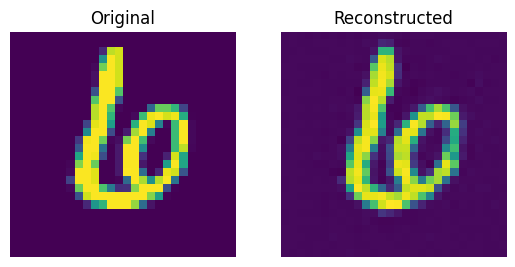

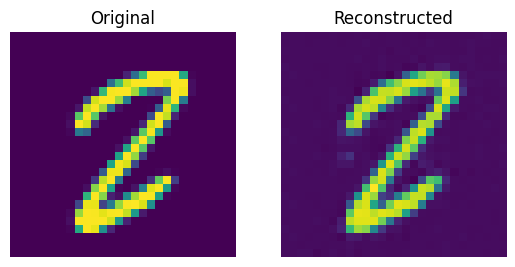

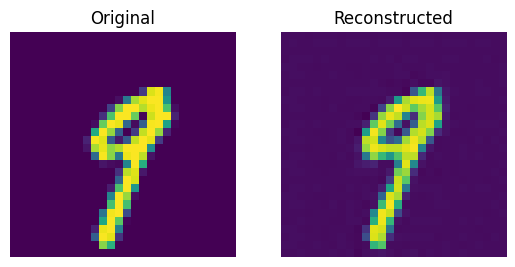

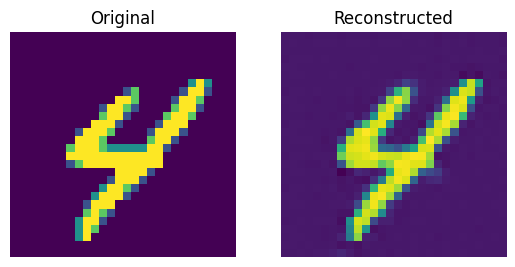

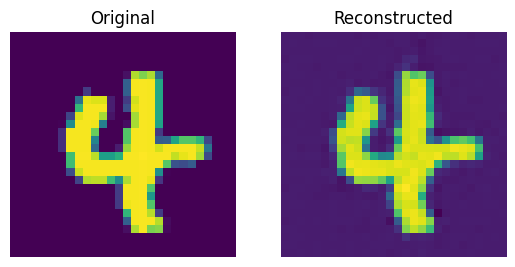

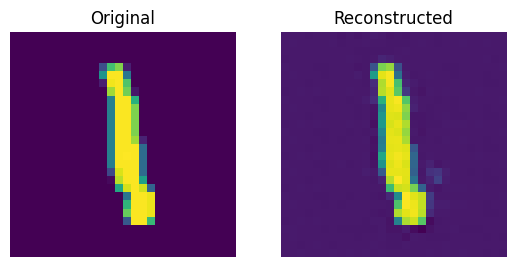

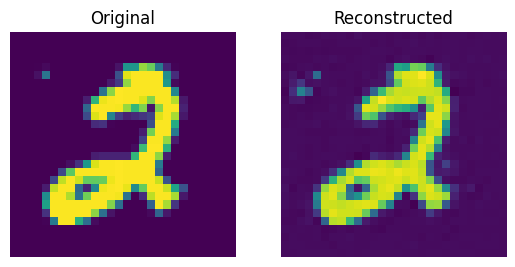

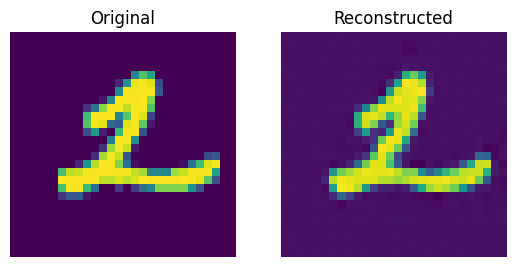

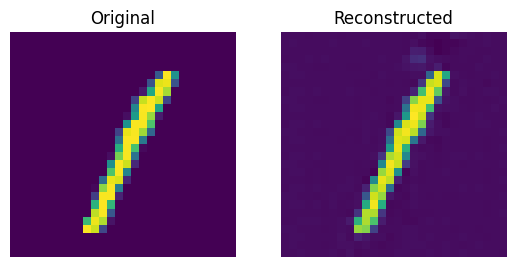

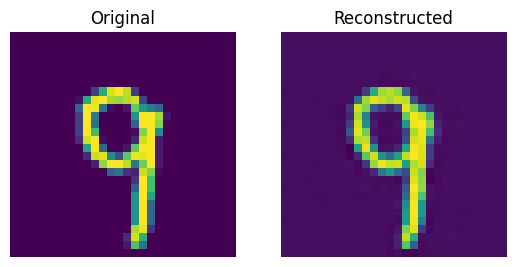

In [100]:
# Reconstruction results on the test set
def show_subplot(original, reconstructed):
    plt.subplot(1, 2, 1)
    plt.imshow(original.squeeze() + 0.5)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(reconstructed.squeeze() + 0.5)
    plt.title("Reconstructed")
    plt.axis("off")

    plt.show()


trained_rvqvae_model = rvqvae_trainer.rvqvae
idx = np.random.choice(len(x_test_scaled), 10)
test_images = x_test_scaled[idx]
reconstructions_test = trained_rvqvae_model.predict(test_images)

for test_image, reconstructed_image in zip(test_images, reconstructions_test):
    show_subplot(test_image, reconstructed_image)

### Question 3 (Total 40 marks)

a) Design, implement and train a VQ-VAE for the spoken digit dataset. You are free to choose any architecture for the encoder and decoder networks, but your model should use the custom RVQ layer from question 2, with $N_q\ge2$ codebooks. (If you have been unable to implement this custom layer, then you should use the `VectorQuantizer` layer from the [Keras website](https://keras.io/examples/generative/vq_vae/)). You can also make additions or modifications to the training algorithm if you wish.

Your trained model should output a sequence of codebook vectors using the encoder and RVQ layer, which are then decoded by the decoder network to reconstruct the original input.

You should record any experiments you carry out along with the training logs, to be reported in question 4. Your code in this question does not need to be presented so that it runs all experiments, it can be set out to run the best experiment only.

Display some examples (playable using the `Audio` class from the `IPython.display` module as in question 1) from the dataset along with their reconstructions to demonstrate the trained model.

**(25 marks)**

In [ ]:
# 

b) The VQ-VAE quantisation layer emits a sequence of discrete codes for a given audio input. During training, the prior distribution over these codes is kept uniform. In order to use the model to generate audio, it is necessary to train a second model to predict likely sequences of codebook vectors. 

This second model is usually referred to in the literature as a 'prior' model (note that this is not really a prior, as it is trained on the data). We will adopt this same terminology here.

You should design, implement and train a prior model to generate sequences of codebook vectors, using the output of the trained VQ-VAE encoder and quantisation stage, using the same training data that was used to train the VQ-VAE. You are again free to choose any architecture for the prior model.

Your trained model should generate a sequence that can be decoded by the VQ-VAE to output audio.

You should record any experiments you carry out along with the training logs, to be reported in question 4. Your code in this question does not need to be presented so that it runs all experiments, it can be set out to run the best set of hyperparameters, according to your validation results. You should aim to try at least two sets of hyperparameters.

Display some examples (playable using the Audio class from the IPython.display module as in question 1) generated using your prior and VQ-VAE model.

**(15 marks)**

### Question 4 (Total 15 marks)

Provide a separate PDF report with an account of the models and experiment design you have made in question 3. Your report should include details of the choices you have made throughout the development of the models, including the data processing, architecture design, hyperparameter settings/experiments and training algorithm. Where appropriate, you can also provide your intuition behind these choices. 

Your report should also include the results from your experiments, highlighting the best choice of hyperparameters that you found. If you encountered difficulties to successfully train the model(s) you should report these, and if possible suggest what you think might be potential reasons for these difficulties. Are there additional experiments or modifications to the model and/or training algorithm that you would have liked to make given more time?

Marks will be awarded for presentation and clarity. Your report should be no more than 2-3 pages.

**(15 marks)**